<a href="https://colab.research.google.com/github/cctbx/cctbx_tutorials/blob/main/struktura_2024/Struktura_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to CCTBX**

The CCTBX project (computational crystallography toolbox) initially started as a library containing algorithms for the handling of unit cells, space groups, and atomic scatterers. Since then it has grown into a large project to support a variety of structural biology workflows, including x-ray and neutron crystallography, cryo-electron microscopy, and x-ray free electron lasers.

The CCTBX library is written in Python, with many of the lower level algorithms accelerated using C++ via the Boost Python bindings.

The principal high-level cctbx objects are:

*   Data Manager: Read and write files and keep track of them
*   Model Manager: A molecular model or models and restraints that go with them
*   Map Manager: A 3D map or maps and information about gridding and map symmetry
*   Map Model Manager: One or more related maps and models as a group
*   F-Model Manager: Combines a model and a related Miller array (map coefficeints, or other data for each index of a map)

These high-level cctbx objects are composed of lower-level objects that implement various concepts in macromolecular crystallography, which are in turn composed of CCTBX flex arrays for efficient computation of numerical data. Finally, user defined parameters are managed and shared betwen objects using the CCTBX Phil module.

The examples presented here aim to illustrate working with the core CCTBX data types using example data. Much of the content is adapted from the official CCTBX documentation: http://cci.lbl.gov/docs/cctbx/

# **Setting up cctbx**
First we need to set up the cctbx in this colab. Execute the following cells to install condacolab.



In [1]:
#@title Install condacolab so that conda packages can be used

# Install condacolab so that conda packages can be used
# https://github.com/conda-incubator/condacolab
#
# Important notes
# https://github.com/conda-incubator/condacolab#shortcomings
# 1) The kernel will automatically be restarted and show an error message about
#    a crash ("Your session crashed for an unknown reason").
#    The error can be ignored.
# 2) Only the "base" environment is available, so do not create a separate
#    environment for packages.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:13
🔁 Restarting kernel...


In [1]:
#@title Install cctbx-base
# Wait until the error message appears near the bottom of the notebook before
# proceeding.
!conda install -q cctbx-base

# conda installs ${CONDA_PREFIX}/share/cctbx into /usr/local instead of /usr
# Make a copy to avoid errors
!cp -af /usr/local/share/cctbx /usr/share/

# sys.path does not have some directories with libraries, so add them here
import sys
py_ver = f'{sys.version_info.major}.{sys.version_info.minor}'
for d in [f'/usr/local/lib/python{py_ver}/lib-dynload', '/usr/local/lib']:
  if d not in sys.path:
    sys.path.insert(0, d)

# final check
import os
if os.path.isdir('/usr/local/share/cctbx') \
  and f'/usr/local/lib/python{py_ver}/lib-dynload' in sys.path \
  and '/usr/local/lib' in sys.path:
  print('Finished installing cctbx-base')
else:
  raise RuntimeError('There was an error fixing up the installation of cctbx-base')


Channels:
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cctbx-base


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    biopython-1.84             |  py310hc51659f_0         2.7 MB  conda-forge
    brotli-1.1.0               |       hd590300_1          19 KB  conda-forge
    brotli-bin-1.1.0           |       hd590300_1          19 KB  conda-forge
    ca-certificates-2024.8.30  |       hbcca054_0         155 KB  conda-forge
    cctbx-base-2024.8          |  py310h159de0f_0        61.0 MB  conda-forge
    certifi-2024.8.30          |     pyhd8ed1ab_0         160 KB  conda-forge
    contourpy-1.3.0            |  py310h3788b33_1         252 KB  conda-forge
    cycler-0.12.1              |     pyhd8ed1ab_0          13 KB  conda-forge
    fonttools-4.53.1           |  py310ha75aee5

# **Test installation**

Let's check if everything worked by running some cctbx code.

We'll create 100 random numbers in a flex array. Then we print some properties of this array, i.e. the smallest value and the length of the array.

In [2]:
from scitbx.array_family import flex
a = flex.random_double(100)
print('Smallest value among the 100 values: ', flex.min(a))
print('Size of the array: ', a.size())

Smallest value among the 100 values:  0.004111466037330924
Size of the array:  100



Thanks to Georg Mlynek for this example!


In [3]:
from cctbx import crystal, miller

crystal_symmetry = crystal.symmetry((10, 20, 30, 90, 90, 90), 'P212121')
ms = miller.build_set(
    crystal_symmetry=crystal_symmetry,
    anomalous_flag=True,
    d_min=2,
    d_max=10
)
crystal_symmetry.show_summary()
print('Resolution range', ms.d_max_min())
print('Number of reflections', ms.indices().size())

Unit cell: (10, 20, 30, 90, 90, 90)
Space group: P 21 21 21 (No. 19)
Resolution range (10.0, 2.0)
Number of reflections 762


# **File IO with the DataManager**

When you want to perform some actions on data or a model, you have to start with reading the file. Once the action is done, you probably want to write the files.

To do this conveniently, you can use the cctbx DataManager. The DataManager lets you read and write files describing atomic models, restraints, reflection data files, symmetry files, sequence files, and MRC/CCP4 format map files.

First, download an example file from the PDB (model 1aba):

In [4]:
!wget https://files.rcsb.org/view/1ABA.pdb

--2024-09-15 18:40:01--  https://files.rcsb.org/view/1ABA.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.159.245
Connecting to files.rcsb.org (files.rcsb.org)|128.6.159.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘1ABA.pdb’

1ABA.pdb                [ <=>                ]  95.71K  --.-KB/s    in 0.09s   

2024-09-15 18:40:02 (1011 KB/s) - ‘1ABA.pdb’ saved [98010]



We can also run linux shell commands from Colab cells, either using the %shell syntax, or the ! prefix for a single line. Lets check if we got our example files.

In [5]:
! ls

1ABA.pdb  condacolab_install.log  sample_data


Then let's read in this model file with the DataManager (this works for mmcif files, too!).

In [6]:
from iotbx.data_manager import DataManager
dm = DataManager()
model_1 = "1ABA.pdb"
dm.process_model_file(model_1)

'1ABA.pdb'

The data manager has now read our file. If desired, a single DataManager instance can read many files and store them simultaneously. To access objects from a specific file, we can request it using the filename as the key. Here we create a model object (we'll see more on that later) for structure 1ABA.


In [7]:
model_1_obj = dm.get_model(filename=model_1)

To save a model to the disk, we also use the DataManager. One of its many advantages is the ability to handle multiple file formats transparently.

In [8]:
filename_cif = "1aba_model.cif"
dm.write_model_file(model_1_obj, filename=filename_cif, format="cif", overwrite=True)

'1aba_model.cif'

Lets check to make sure it worked. The following command shows the first 20 lines of the 1ABA mmcif file.


In [9]:
! head 1aba_model.cif -n 20

data_default
_cell.length_a                    30.200
_cell.length_b                    47.800
_cell.length_c                    61.300
_cell.angle_alpha                 90.000
_cell.angle_beta                  90.000
_cell.angle_gamma                 90.000
_cell.volume                      88490.228
_space_group.crystal_system       orthorhombic
_space_group.IT_number            19
_space_group.name_H-M_alt         'P 21 21 21'
_space_group.name_Hall            ' P 2ac 2ab'
_symmetry.space_group_name_H-M    'P 21 21 21'
_symmetry.space_group_name_Hall   ' P 2ac 2ab'
_symmetry.Int_Tables_number       19
loop_
  _space_group_symop.id
  _space_group_symop.operation_xyz
   1 x,y,z
   2 x+1/2,-y+1/2,-z


The DataManager can handle data files, too. Let's get the reflection file for model 1ABA.

In [10]:
!rm 1ABA-sf.cif 1ABA-sf.cif.gz 1ABA.mtz
!wget https://files.rcsb.org/download/1ABA-sf.cif.gz
!gunzip 1ABA-sf.cif.gz
!ls

rm: cannot remove '1ABA-sf.cif': No such file or directory
rm: cannot remove '1ABA-sf.cif.gz': No such file or directory
rm: cannot remove '1ABA.mtz': No such file or directory
--2024-09-15 18:40:58--  https://files.rcsb.org/download/1ABA-sf.cif.gz
Resolving files.rcsb.org (files.rcsb.org)... 128.6.159.245
Connecting to files.rcsb.org (files.rcsb.org)|128.6.159.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100519 (98K) [application/octet-stream]
Saving to: ‘1ABA-sf.cif.gz’

1ABA-sf.cif.gz      100%[===================>]  98.16K  --.-KB/s    in 0.1s    

2024-09-15 18:40:58 (693 KB/s) - ‘1ABA-sf.cif.gz’ saved [100519/100519]

1aba_model.cif	1ABA.pdb  1ABA-sf.cif  condacolab_install.log  sample_data


You can convert the structure factor cif file to mtz with the following command. You could also do it on a lower level (operating with miller arrays - we'll cover these later), but this way may be the easiest.

In [11]:
from mmtbx.command_line import cif_as_mtz
cif_as_mtz.run(args=[
    "1ABA-sf.cif",
    "--symmetry=1ABA.pdb",
    "--merge",
    "--output_file_name=1ABA.mtz"])

Can't determine output label for r1abasf,_refln.crystal_id - skipping.
Can't determine output label for r1abasf,_refln.wavelength_id - skipping.
Can't determine output label for r1abasf,_refln.scale_group_code - skipping.


Let's check if the file has been created.

In [12]:
!ls

1aba_model.cif	1ABA.mtz  1ABA.pdb  1ABA-sf.cif  condacolab_install.log  sample_data


Now let's read this file with the DataManager.

In [13]:
dm.process_miller_array_file('1ABA.mtz')

'1ABA.mtz'

Now your DataManager has processed the model and the data for structure 1ABA. We are ready to create cctbx objects and do something with them. Let's start with the model object.

# **The cctbx model object**

 The cctbx model object stores all information related to a molecular model. This includes the molecular composition, space group and symmetry information, information about stereochemical restraints, and any metadata that was available in the input file.

 This is how you get the model object from the DataManager.



In [14]:
model_1_ob = dm.get_model(filename=model_1)

 The model object has a lot of methods, you can list them with the the `dir` function.

In [15]:
print(dir(model_1_ob))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_all_monomer_mappings', '_anomalous_scatterer_groups', '_append_pdb_atoms', '_atom_selection_cache', '_biomt_expanded', '_biomt_mtrix_container_is_good', '_clash_guard_msg', '_crystal_symmetry', '_ener_lib', '_expand_symm_helper', '_figure_out_cs_to_output', '_figure_out_hierarchy_to_output', '_get_selection_manager', '_get_ss_annotations_for_output', '_has_hd', '_info', '_master_sel', '_model_input', '_model_number', '_mon_lib_srv', '_monomer_parameters', '_mtrix_expanded', '_ncs_groups', '_ncs_obj', '_neutralized', '_original_model_format', '_pdb_hierarchy', '_pdb_interpretation_params', '_processed', '_processed

## How to access metadata
First we will consider the model metadata which is stored in the model input object. In contrast to the model composition which is highly structured data, the model input can vary substantially depending on the source of the file and what the authors chose to include. Lets take a look at the model input for this file. Execute the cell below to get the model_input object.

In [16]:
model_input= model_1_ob.get_model_input()

Now let's print out some characteristics.| Some fields are structured, and are directly accessible by member functions.

In [17]:
print(model_input.file_type())
print(model_input.get_experiment_type())
print(model_input.get_program_name())
print(model_input.deposition_date())
print(model_input.resolution())
print(model_input.sequence_from_SEQRES())

pdb
X-RAY DIFFRACTION
X-PLOR
1992-04-24
1.45
>chain A
MFKVYGYDSNIHKCGPCDNAKRLLTVKKQPFEFINIMPEKGVFDDEKIAELLTKLGRDTQIGLTMPQVFAPDGSHIGGFDQLREYFK


The entire contents of the file are retained, and can be parsed to extract miscellaneous fields. Note that some fields relating to the data may not be populated.

In [18]:
# Get the whole title section of the pdb
print("\n".join(model_input.title_section()))

HEADER    ELECTRON TRANSPORT                      24-APR-92   1ABA
TITLE     THE STRUCTURE OF OXIDIZED BACTERIOPHAGE T4 GLUTAREDOXIN (THIOREDOXIN).
TITLE    2 REFINEMENT OF NATIVE AND MUTANT PROTEINS
COMPND    MOL_ID: 1;
COMPND   2 MOLECULE: GLUTAREDOXIN;
COMPND   3 CHAIN: A;
COMPND   4 ENGINEERED: YES
SOURCE    MOL_ID: 1;
SOURCE   2 ORGANISM_SCIENTIFIC: ENTEROBACTERIA PHAGE T4;
SOURCE   3 ORGANISM_TAXID: 10665
KEYWDS    ELECTRON TRANSPORT
EXPDTA    X-RAY DIFFRACTION
AUTHOR    H.EKLUND,M.INGELMAN,B.-O.SODERBERG,T.UHLIN,P.NORDLUND,M.NIKKOLA,
AUTHOR   2 U.SONNERSTAM,T.JOELSON,K.PETRATOS
REVDAT   3   05-JUN-24 1ABA    1       REMARK SEQADV
REVDAT   2   24-FEB-09 1ABA    1       VERSN
REVDAT   1   31-OCT-93 1ABA    0
JRNL        AUTH   H.EKLUND,M.INGELMAN,B.O.SODERBERG,T.UHLIN,P.NORDLUND,
JRNL        AUTH 2 M.NIKKOLA,U.SONNERSTAM,T.JOELSON,K.PETRATOS
JRNL        TITL   STRUCTURE OF OXIDIZED BACTERIOPHAGE T4 GLUTAREDOXIN
JRNL        TITL 2 (THIOREDOXIN). REFINEMENT OF NATIVE AND MUTANT PROT

You can also access specific REMARK records, such as REMARK 3.

In [19]:
remark_3_records = model_input.extract_remark_iii_records(3)
for rem in remark_3_records[:6]:
  print(rem)

REMARK   3 REFINEMENT.
REMARK   3   PROGRAM     : X-PLOR
REMARK   3   AUTHORS     : BRUNGER
REMARK   3  DATA USED IN REFINEMENT.
REMARK   3   RESOLUTION RANGE HIGH (ANGSTROMS) : 1.45
REMARK   3   RESOLUTION RANGE LOW  (ANGSTROMS) : NULL


## Crystal Symmetry
The crystal symmetry object stores structured data about the unit cell and space group

In [20]:
crystal_symmetry = model_1_ob.crystal_symmetry()
crystal_symmetry.show_summary()

Unit cell: (30.2, 47.8, 61.3, 90, 90, 90)
Space group: P 21 21 21 (No. 19)


Here is how you can get the unit cell, space group, and operators.

In [21]:
# unit cell
print(crystal_symmetry.unit_cell())
# space group number
print(crystal_symmetry.space_group_number())
# symbol and number
print(crystal_symmetry.space_group_info().symbol_and_number())
# space group operators
ops = crystal_symmetry.space_group().all_ops()
for op in ops:
  print(op)

(30.2, 47.8, 61.3, 90, 90, 90)
19
P 21 21 21 (No. 19)
x,y,z
x+1/2,-y+1/2,-z
-x,y+1/2,-z+1/2
-x+1/2,-y,z+1/2


# The pdb hierarchy
The pdb hierarchy is the cctbx object that represents the information stored in a model file. In particular, this object maintains the hierarchical view of the model. It is independent of the original file format, i.e. the hierarchy object doesn't know or care if the original file was a PDB file, mmCIF file, or any other molecular file format.

Let's get the pdb hierarchy for our toy example.

In [22]:
hierarchy = model_1_obj.get_hierarchy()

Now let's have a look at the compososition of the model. How many chains are in this model? How many ligands?

In [23]:
print(hierarchy.composition())

group_args
  n_atoms                        : 880
  n_chains                       : 2
  n_hd                           : 0
  n_nucleotide                   : 0
  n_nucleotide_atoms             : 0
  n_other                        : 1
  n_other_atoms                  : 12
  n_protein                      : 87
  n_protein_atoms                : 728
  n_water                        : 140
  n_water_atoms                  : 140
  other_cnts                     : Counter({'MES': 1})


The composition method returns a group_args object. This is a CCTBX object that is commonly returned as the result from CCTBX programs and methods. The advantage of the group_args object is that the contents can be accessed using dot syntax, ie:

In [24]:
comp = hierarchy.composition()
n_atoms = comp.n_atoms
print(n_atoms)

880


### Architecture of the hierarchy object

```
model(s)
  id
  chain(s)
    id
    residue_group(s)
      resseq
      icode
      atom_group(s)
        altloc,
        resname
          atom(s)
            name
            element
            charge
            xyz
            occ
            b
```
 - The model, chain, and atom levels of the hierarchy object are probably immediately obvious to someone familiar with the content of model files (such as a PDB file). Note that that is no 'residue' level in the data structure. Instead, there are the two types residue_group and atom_group. They are related to alternative conformations.

 - If there are no alternative conformations in the model, all residue groups contain exactly one atom group, which contains all the atoms of a residue. A file with alternative conformations will lead to residue groups with multiple atom groups, one for each conformer. (Note: about a quarter of the files in the PDB database contain alternative conformations).


### Looping over the hierarchy

It is often useful to loop over the hierarchy to perform actions on certain components of the model.

In [25]:
for m in hierarchy.models():
  for chain in m.chains():
    for rg in chain.residue_groups():
      for ag in rg.atom_groups():
        for atom in ag.atoms():
          # your code here
          pass

Let's print something for every tyrosine residue in the model.

In [26]:
for m in hierarchy.models():
  for chain in m.chains():
    for rg in chain.residue_groups():
      for ag in rg.atom_groups():
        if ag.resname == 'TYR':
          print('TYR ', rg.resseq)

TYR     5
TYR     7
TYR    85
TYR    85
TYR    85


There are three identical lines in the output for Tyrosine 85.

Do you have any idea why that could be?

In the following cell, try to play a bit with the elements of the hierarchy. You can use dir() to list the methods available for the components.

In [27]:
for m in hierarchy.models():
  for chain in m.chains():
    for rg in chain.residue_groups():
      for ag in rg.atom_groups():
        if ag.resname == 'TYR':
          print('TYR ', rg.resseq)

TYR     5
TYR     7
TYR    85
TYR    85
TYR    85


Here is an example of what you could have come up with.

In [28]:
for m in hierarchy.models():
  for chain in m.chains():
    for rg in chain.residue_groups():
      for ag in rg.atom_groups():
        if ag.resname == 'TYR':
          print('TYR ', rg.resseq, ag.altloc)

TYR     5 
TYR     7 
TYR    85 
TYR    85 A
TYR    85 B


Tyrosine 85 has a double conformation which is split at the Calpha atom. This is why there are three atom groups. One for the common part (altloc is blank), one for conformation A and one for conformation B.

## Histogram of B-factors

Now let's make a histogram of isotropic B-factors.

First, we extract the isotropic ADPs. There are several ways to do this. Here is the way using the model object.

In [29]:
b_iso = model_1_obj.get_b_iso()
print(b_iso)

As you can see, the B-factors are stored in a flex array, which are numerical arrays implemented in C++. They have a lot in common with  Numpy arrays.

Note that we can create a Numpy array from a Flex array. This is useful for passing data on to other libraries based on Numpy.

In [30]:
b_iso_np = b_iso.as_numpy_array()

Let's print some properties of this flex array of isotropic B-factors.

In [31]:
print(b_iso.size())
print(b_iso.min_max_mean().min)
print(b_iso.min_max_mean().max)

880
7.36
107.99


Now let's plot a histogram of isotropic B-factors.

Text(0, 0.5, 'Count')

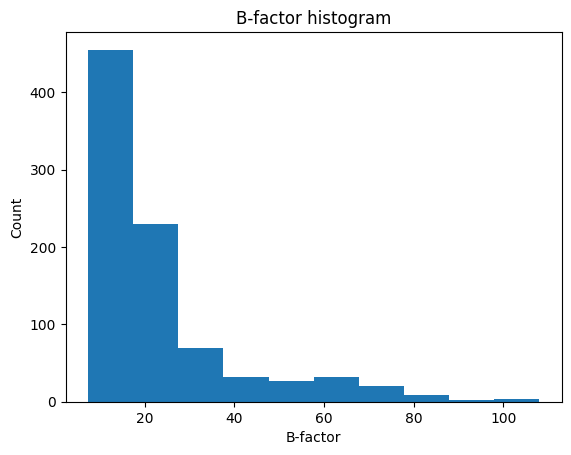

In [32]:
import matplotlib.pyplot as plt
_ = plt.hist(b_iso)
plt.title("B-factor histogram")
plt.xlabel("B-factor")
plt.ylabel("Count")

Is this histogram really useful? It does not make any distinction between protein residues, water or other components of the model.
Let's look at a B-factor histogram for water molecules only.
We can easily do this with selections.

In [34]:
b_iso_water = model_1_obj.select(model_1_obj.selection("resname HOH")).get_b_iso()


What is happening here? The inner statement (`model.selection("resname HOH")`) parses the string selection, and turns it into a boolean flex array. Each value in the array relates to an atom in the model, and the value True/False corresponds to whether or not the atom was selected by the selection string.

Text(0, 0.5, 'Count')

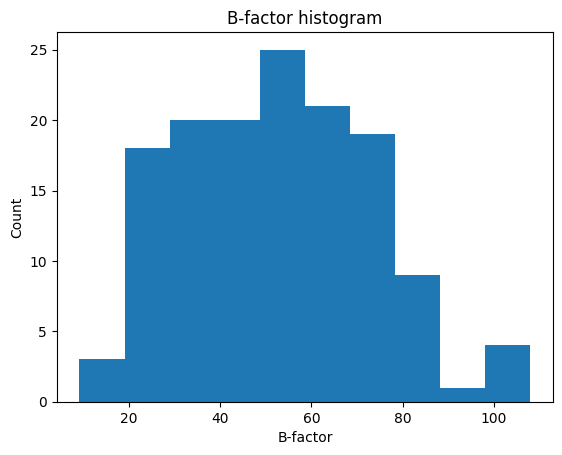

In [35]:
_ = plt.hist(b_iso_water)
plt.title("B-factor histogram")
plt.xlabel("B-factor")
plt.ylabel("Count")

According to this plot, the water molecules occupy the right tail region from our first histogram. This is mostly expected. Many water molecules are located in the outer regions of the protein and have typically higher B-factors than the protein residues.

## More on Selections

In many cases it is desireable to process a subset of a model. Fortunately, the model object supports a variety of string selections. In many cases this can enable you to skip looping over the hierarchy.

Let's go back to our example where we looped over the entire hierarchy to print out the residue number of Tyrosine residues. We could have done this in a slightly different way by using selections. Let's see how.

First, let's figure out the selection string for the tyrosines.

In [ ]:
# Try out creating a selection with model.selection() method
# sel_tyr = model.selection('put_your_sel_string_here')

Options for string selections are documented on the Phenix Documentation:

https://phenix-online.org/documentation/reference/atom_selections.html

In [36]:
sel_tyr = model_1_obj.selection('resname TYR')

What is sel_tyr? It is a boolean flex array. It has as many entries as the number of atoms. One can imagine the array like a spreadsheet, each row representing one atom in the model (the order is not necessarily the same as in the input file!). For some atoms, i.e. those that are in a tyrosine residue, the value is True, for all other atoms, the value is False.

In [37]:
# type
print(type(sel_tyr))
# size
print(sel_tyr.size())
# how many "true" values
print(sel_tyr.count(True))

<class 'scitbx_array_family_flex_ext.bool'>
880
43


Now we know that 43 atoms are part of tyrosines. We don't know yet how many tyrosine residues are in the model, though.

Let's get a subset of the hierarchy that only contains tyr residues.

In [38]:
hierarchy_tyr = model_1_obj.select(sel_tyr).get_hierarchy()

Now we can loop over the residue groups of this smaller hierarchy and we don't have to insert the if-statement in the loop.

In [39]:

for rg in hierarchy_tyr.residue_groups():
  for ag in rg.atom_groups():
    print(ag.resname, rg.resseq, ag.altloc)

TYR    5 
TYR    7 
TYR   85 
TYR   85 A
TYR   85 B


Using selections, make a B-factor histogram for a subset of the input model. You could select residue types, atom types, certain elements, etc.

Text(0, 0.5, 'Count')

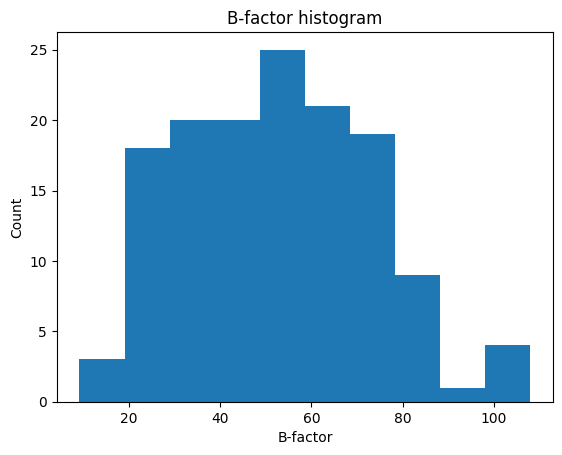

In [40]:
# example for water, replace the string selection with your example
my_b_iso = model_1_obj.select(model_1_obj.selection("resname HOH")).get_b_iso()
_ = plt.hist(my_b_iso)
plt.title("B-factor histogram")
plt.xlabel("B-factor")
plt.ylabel("Count")

# Working with diffraction data

## Miller Arrays

Miller arrays are containers for experimental (or calculated data). A miller array contains the crystal symmetry, an array of Miller indices (h,k,l), a boolean flag indicating anomalous pairs and a flex array containing data (X-ray amplitudes or intensities, experimental sigmas, etc.).

Let's get the miller arrays for our example file (1ABA.mtz). We have read this file earlier with the DataManager.

In [41]:
miller_arrays = dm.get_miller_arrays(filename='1ABA.mtz')

Let's see what arrays are in the mtz file.

In [42]:
labels=dm.get_miller_array_labels()
for l in labels: print(l)

R-free-flags
FOBS,SIGFOBS


Let's get separate miller arrays for each one, so we can operate on them.

In [43]:
R_free_flags, Fobs = dm.get_miller_arrays(labels=['R-free-flags', 'FOBS,SIGFOBS'])


Let's print some information of the Fobs array.

In [44]:
print("Resolution limits:", Fobs.d_max_min())
print("Space group info:",Fobs.space_group_info())
print("Completeness:",Fobs.completeness())
print("Size:",Fobs.size())

Resolution limits: (37.694584205526446, 1.4468216064014867)
Space group info: P 21 21 21
Completeness: 0.9839445356686736
Size: 16179


Let's have a closer look at the R-free array.

In [69]:
print("Resolution limits:", R_free_flags.d_max_min())
print("Space group info:",R_free_flags.space_group_info())
print("Completeness:",R_free_flags.completeness())
print("Size:",R_free_flags.size())

Resolution limits: (37.694584205526446, 1.4468216064014867)
Space group info: P 21 21 21
Completeness: 0.9839445356686736
Size: 16179


So far, all looks good. Same space group, same resolution, completeness and size.

Let's have a look at the values.

In [70]:
print(R_free_flags.data()[0])
print(R_free_flags.data().all_eq(1))

1
True


It looks like all values of the R-free-flag array are equal to 1. So it actually does not allow selecting any reflections for calculating R-free.

Let's make a new R-free array, so we can use it to calculate R-factors.

In [71]:
R_free_flags_new = Fobs.generate_r_free_flags()

In [96]:
import mmtbx
f_model = mmtbx.f_model.manager(
  f_obs          = Fobs,
  r_free_flags   = R_free_flags_new,
  xray_structure = model_1_obj.get_xray_structure())

In [100]:
_ = f_model.update_all_scales()

RuntimeError: mmtbx Internal Error: /home/conda/feedstock_root/build_artifacts/cctbx-split_1725241892653/work/modules/cctbx_project/mmtbx/bulk_solvent/bulk_solvent.h(987): MMTBX_ASSERT(fm_abs > 0) failure.

In [109]:
fmodel_params = dm.get_fmodel_params()
fmodel_params.xray_data.r_free_flags.generate = True
dm.set_fmodel_params(fmodel_params)
fmodel = dm.get_fmodel(scattering_table = 'x_ray')
_ = fmodel.update_all_scales()

Now we will print out the R-work and R-free values


In [110]:
print("R-work:",fmodel.r_work())
print("R-free:",fmodel.r_free())

R-work: 0.20617641662009625
R-free: 0.2170830173672565


In [ ]:
from libtbx.program_template import ProgramTemplate
from libtbx.utils import Sorry

class TestProgram(ProgramTemplate):
  program_name = "new_program"
  description = """
This is a demo of my new program
"""
  master_phil_str = """
general_param = None
  .type = str
  .help = A general parameter that is a string
bool_param = None
  .type = bool
  .help = Something that is True or False
parameter_section {
  specific_param_1 = 0
    .type = int
    .help = This is an example of a numerical parameter in a PHIL section
  specific_param_2 = 3.14
    .type = float
    .help = This is another example
}
"""
  def validate(self):
    if self.params.parameter_section.specific_param_1 < 0:
      raise Sorry("The specific_param_1 must be 0 or greater")

  def run(self):
    # just add some numbers
    self.results = self.params.parameter_section.specific_param_1 + self.params.parameter_section.specific_param_2
    self._print(self.results)

  def get_results(self):
    return self.results

In [ ]:
from iotbx.cli_parser import run_program

#run_program(program_class=TestProgram, args=[])
run_program(program_class=TestProgram, args=['bool_param=False', 'param_1=10'])

Starting new_program
on Tue Sep 10 18:21:46 2024 by root

Processing files:
-------------------------------------------------------------------------------

  No files found

Processing PHIL parameters:
-------------------------------------------------------------------------------

  Adding command-line PHIL:
  -------------------------
    bool_param=False
    param_1=10

Final processed PHIL parameters:
-------------------------------------------------------------------------------
  bool_param = False
  parameter_section {
    specific_param_1 = 10
  }


Starting job
13.14

Job complete
usr+sys time: 17.32 seconds
wall clock time: 17.35 seconds


13.14